# Signal 1, also known as Day1 signal

The starting point for the post result project

**Index**
- Packages
- Data acquisition
- Utility functions
    - General helper
    - Signal functions
    - Performance utility functions
- Average return trajectory for short
- Account curve for long
    - Variations including time periods, entry point, question around earning, stop loss, moving average, high, size, country, sector, PE, market correlation
    - Possible combinations of signal building blocks
    - US vs Europe
- Average return trajectory for short
- Account curve for short
    - Same logic
- Build a portfolio
- Logistic regression    


## 1 - Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


%matplotlib inline

## 2 - Data acquisition

Store the data in excel and extract them from following functions
- Fundamental data including revision, market cap, volume, PE, sector
- Absolute price, relative price, absolute return, relative return

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_Europe=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_Europe:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2017.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>5)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [4]:
tabs_US=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property','EPS','Broker']

# US
data_dict_US={}

for s in tabs_US:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\US 2007-2017.xlsx',sheet_name=s))
    data_dict_US[s]=df

# select the right universe for US
universe_evaluate_US=(data_dict_US["Market cap"]>500)&(data_dict_US["Volume"]>5)
data_dict_US["Revision"]=data_dict_US["Revision"][universe_evaluate_US]
data_dict_US["Market cap"]=data_dict_US["Market cap"][data_dict_US["Market cap"]>500]

In [5]:
tabs_Asia=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property','EPS','Broker','Mapping']

# Asia
data_dict_Asia={}

for s in tabs_Asia:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Asia 2007-2017.xlsx',sheet_name=s))
    country=df.apply(lambda x:x.name[-2:] if type(x.name)==str else 0,axis=1)
    data_dict_Asia[s]=df[country!="IN"]

# select the right universe for Asia
universe_evaluate_Asia=(data_dict_Asia["Market cap"]>500)&(data_dict_Asia["Volume"]>5)
data_dict_Asia["Revision"]=data_dict_Asia["Revision"][universe_evaluate_Asia]
data_dict_Asia["Market cap"]=data_dict_Asia["Market cap"][data_dict_Asia["Market cap"]>500]

In [6]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [7]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price 2007-2017.xlsx',2006,2017)
price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US price 2007-2017.xlsx',2006,2017)
price_Asia=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Asia price 2007-2017.xlsx',2006,2017)

In [8]:
def get_return(price_df,open_price,benchmark,sector_df):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    #rel_return_sector=abs_return.dropna(axis=0,how='all').apply(lambda x: x-abs_return.loc[sector_df.loc[x.name].Index] if x.name[-2:]!='CN' and x.name[-3:-2]==' ' and not pd.isnull(sector_df.loc[x.name].Index) else x,axis=1)
    abs_open_ret=open_price/price_df.shift(1,axis=1)-1
    rel_open_ret=abs_open_ret-abs_open_ret.loc[benchmark]
    return rel_price,abs_open_ret,rel_open_ret,abs_return,rel_return,#rel_return_sector

In [9]:
def get_return_Asia(price_df,mapping_df):
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    stock_return=abs_return.copy()
    stock_return["country"]=stock_return.apply(lambda x:x.name[-2:],axis=1)
    stock_return=stock_return[(stock_return["country"]!='ex')&(stock_return["country"]!='IN')]
    stock_return["Index"]=stock_return["country"].apply(lambda x: mapping_df.loc[x].iloc[0]).values
    benchmark_return=stock_return.apply(lambda x:abs_return.loc[x.Index],axis=1)
    rel_return=stock_return.iloc[:,:-2] - benchmark_return
    rel_return=rel_return.dropna(how='all',axis=0)
    return abs_return,rel_return,benchmark_return

In [10]:
# get return dfs
rel_price_Europe,abs_open_ret_Europe,rel_open_ret_Europe,abs_return_Europe,rel_return_Europe=get_return(price_Europe,price_Europe,'SX5E Index',data_dict_Europe["Property"])
rel_price_US,abs_open_ret_US,rel_open_ret_US,abs_return_US,rel_return_US=get_return(price_US,price_US,'SPX Index',data_dict_US["Property"])
rel_price_Asia,abs_open_ret_Asia,rel_open_ret_Asia,abs_return_Asia,rel_return_Asia=get_return(price_Asia,price_Asia,'MXAP Index',data_dict_Asia["Property"])

In [11]:
abs_return_Asia,rel_return_Asia,benchmark_return_Asia=get_return_Asia(price_Asia,data_dict_Asia["Mapping"])

## 3 - Utility functions

Collect all the utility functions in one place


### 3.1 General helper functions
- Calculation incl. nmove, vol, sector, market cap, EAR
- AUTOR, MA

In [12]:
def slice_universe(signal_df,start_datetime,end_datetime):
    entry=signal_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
    period_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
    adj_signal_df=signal_df.loc[:,period_evaluate]
    adj_signal_df=adj_signal_df.loc[start_datetime:end_datetime]
    
    zero_index=pd.date_range(start_datetime,end_datetime,freq='B').to_frame()
    adj_signal_df=pd.concat([adj_signal_df,zero_index],axis=1).iloc[:,:-1]
    return adj_signal_df
    

In [13]:
# utility function to obtain the gap return
def gap_return_calc(ticker,date,open_ret):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    open_ret_series=open_ret.loc[ticker].dropna()
    date_series=open_ret_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        ret=open_ret_series.iloc[day0]   
        return ret
    else:
        return None

In [14]:
# utility function to obtain the gap
def gap_calc(ticker,date,open_ret,return_df,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    open_ret_series=open_ret.loc[ticker].dropna()
    return_series=return_df.loc[ticker].dropna()
    date_series=open_ret_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=open_ret_series.iloc[day0]
        nmove=ret/vol     
        return nmove
    else:
        return None

In [15]:
# obtain the announcement return dataframe from price return and date dataframe
def gap_df(date_df,open_ret,return_df,vol_lookback):
    gap_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            gap_series=date_row.apply(lambda x: gap_calc(ticker,x,open_ret,return_df,vol_lookback))
            gap_list.append(gap_series)
        else:
            pass
    gap_df=pd.concat(gap_list,axis=1).T
    return gap_df

In [16]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EA_return_calc(ticker,date,return_df,EAR_period):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        return ret
    else:
        return None

In [17]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [18]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            ret_series=date_row.apply(lambda x: EAR_calc(ticker,x,return_df,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

In [19]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

In [20]:
## function to grab volume
def get_volume(ticker,date,volume_df,date_df):
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        volume=volume_series.iloc[location]
        return volume
    except ValueError:
        return None

In [21]:
## function to grab market cap
def get_market_cap(ticker,date,market_cap_df,date_df):
    date_series=date_df.loc[ticker]
    size_series=market_cap_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        size=size_series.iloc[location]
        return size
    except ValueError:
        return None

In [22]:
## function to grab PE
def get_PE(ticker,date,PE_df,date_df):
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None

In [23]:
## function to grab nmove post result
def get_post_nmove(ticker,date,return_df,holding,entry):
    return_series=return_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None   
    try:
        location=return_series.index.tolist().index(timestamp)
        entry_date=return_series.index.tolist()[location+entry]
        nmove=EAR_calc(ticker,entry_date,return_df,holding,30)
        return nmove
    except ValueError:
        return None

In [24]:
## function to grab PE
def get_PE(ticker,date,PE_df,date_df):
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE=PE_series.iloc[location]
        return PE
    except ValueError:
        return None

In [25]:
## function to grab PE premium
def get_PE_premium(ticker,date,PE_premium_df,date_df):
    date_series=date_df.loc[ticker]
    PE_premium_series=PE_premium_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE_premium=PE_premium_series.iloc[location]
        return PE_premium
    except ValueError:
        return None

In [26]:
## function to grab earning revision
def get_revision(ticker,date,revision_df,date_df):
    date_series=date_df.loc[ticker]
    revision_series=revision_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        revision=revision_series.iloc[location]
        return revision
    except ValueError:
        return None

In [27]:
## function to grab price
def get_price(ticker,date,price_df):
    price_series=price_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None
    try:
        price=price_series.loc[timestamp]
        return price
    except ValueError:
        return None

In [28]:
## function to grab EPS
def get_EPS(ticker,date,EPS_df,date_df):
    date_series=date_df.loc[ticker]
    EPS_series=EPS_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        EPS=EPS_series.iloc[location]
        return EPS
    except ValueError:
        return None

In [29]:
## function to grab broker
def get_broker(ticker,date,broker_df,date_df):
    date_series=date_df.loc[ticker]
    broker_series=broker_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        broker=broker_series.iloc[location]
        return broker
    except ValueError:
        return None

In [30]:
# RSI
def RSI(ticker,date,return_df,look_back):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        date=date
    try:
        price_series=return_df.loc[ticker]
        pos=price_series.index.tolist().index(date)
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        up=target_series[target_series>0]
        down=target_series[target_series<0]
        if len(up)==0:
            return 0
        elif len(down)==0:
            return 1
        else:
            RS=-up.mean()/down.mean()
            RSI=100-100/(1+RS)
            return RSI
    except ValueError:
        return None

In [31]:
# AUTOR score and slope
def AUTOR(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        date=date
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]

        regr=linear_model.LinearRegression()
        x_train=np.asarray([x+1 for x in range(min(look_back, pos))]).reshape(-1,1)
        y_train=target_series.values.reshape(-1,1)
        regr.fit(x_train,y_train)  
        slope=regr.coef_
        error=y_train-regr.predict(x_train)
        std_err=np.std(error)
        score=error[-1]/std_err
        return score[0], slope[0][0]
    except ValueError:
        return (None,None)

In [32]:
# MA score 
def MA(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        MA=price_series.rolling(look_back,min_periods=1).mean()

        target_MA=MA[pos-min(look_back, pos)+1:pos+1]
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        if (len(target_MA.dropna())==0)|(len(target_series.dropna())==0):
            return (None,None)
        else:
            MA_score=(target_series.iloc[-1]/target_MA.iloc[-1]-1)/(target_series.diff(1)/target_series.shift(1)).std()
            slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
            return MA_score,slope 
    except ValueError:
        return (None,None)

In [33]:
# MA score 
def MA_distance(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        MA=price_series.rolling(look_back,min_periods=1).mean()

        target_MA=MA[pos-min(look_back, pos)+1:pos+1]
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        if (len(target_MA.dropna())==0)|(len(target_series.dropna())==0):
            return (None,None)
        else:
            MA_score=target_series.iloc[-1]/target_MA.iloc[-1]-1
            slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
            return MA_score,slope 
    except ValueError:
        return (None,None)

In [34]:
def get_high_position(ticker,date,price_df,lookback):
    price_series=price_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None
    try:
        location=price_series.index.tolist().index(timestamp)
        price_range=price_series[location-min(lookback-1,len(price_series[:location])):location+1]
        high=price_range.max()
        low=price_range.min()
        spot=price_range[-1]
        target_range=(spot-low)/(high-low)
        return target_range
    except ValueError:
        return None    

In [35]:
def signal1_range_position(signal_df,price_df,lookback,boundary):
    ind_return=signal_df.cumsum().ffill().iloc[-1].dropna().sort_values()
    ind_return.name="Return"
    return_df=ind_return.to_frame()
    return_df["Position"]=return_df.apply(lambda x:get_high_position(x.name[0],x.name[1],price_df,lookback),axis=1)
    adj_signal_df=signal_df.loc[:,return_df["Position"]>boundary]
    return return_df,adj_signal_df

In [36]:
def get_high_position(ticker,date,price_df,lookback):
    price_series=price_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None
    try:
        location=price_series.index.tolist().index(timestamp)
        price_range=price_series[location-min(lookback-1,len(price_series[:location])):location+1]
        high=price_range.max()
        low=price_range.min()
        spot=price_range[-1]
        target_range=(spot-low)/(high-low)
        return target_range
    except ValueError:
        return None    

In [37]:
def signal1_range_position(signal_df,price_df,lookback,boundary):
    ind_return=signal_df.cumsum().ffill().iloc[-1].dropna().sort_values()
    ind_return.name="Return"
    return_df=ind_return.to_frame()
    return_df["Position"]=return_df.apply(lambda x:get_high_position(x.name[0],x.name[1],price_df,lookback),axis=1)
    adj_signal_df=signal_df.loc[:,return_df["Position"]>boundary]
    return return_df,adj_signal_df

In [38]:
def signal1_filter_high_day2(signal_df,price_df,index_return,rolling_window,day2_only):
    high_df=price_df.rolling(window=rolling_window,axis=1,min_periods=10).max()
    pre_high=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]))
    pre_close=signal_df.apply(lambda x: (price_df.loc[x.name[0]].loc[x.name[1]]))
    distance=pre_high/pre_close-1
    
    index_return=index_return.reindex([pd.Timestamp(datetime.strptime(x,"%d/%b/%Y")) for x in index_return.index])
    signal_abs_df=signal_df.apply(lambda x:x+index_return,axis=0)
    
    signal_abs_cum=((1+signal_abs_df).cumprod()-1).expanding().max()
    cum_evaluate=signal_abs_cum>distance
    cum_evaluate_high=(signal_abs_cum>distance)|(distance==0)

    high_evaluate=high_df==price_df
    signal_high=signal_df.apply(lambda x: (high_evaluate.loc[x.name[0]].loc[x.name[1]]))
    
    if day2_only==False:
        adj_cum_evaluate=cum_evaluate.apply(lambda x: x.shift(1) if signal_high[x.name]==False else cum_evaluate_high[x.name],axis=0)
    else:
        adj_cum_evaluate=cum_evaluate.apply(lambda x: x.shift(1),axis=0)
    
    adj_cum_evaluate=adj_cum_evaluate.fillna(False)
    adj_signal_df=signal_df[adj_cum_evaluate]
    return adj_signal_df

In [39]:
def signal1_filter_RSI(signal_df,return_df,look_back,lower_level,higher_level):
    RSI_filter=signal_df.apply(lambda x: RSI(x.name[0],x.name[1],return_df,look_back),axis=0)
    RSI_evaluate=((RSI_filter>=lower_level)&(RSI_filter<=higher_level))
    signal_filter_RSI=signal_df.loc[:,RSI_evaluate]
    return signal_filter_RSI

In [40]:
def signal1_filter_AUTOR(signal_df,look_back,price_df,lower_level,higher_level,rel_index):
    AUTOR_filter=signal_df.apply(lambda x: AUTOR(x.name[0],x.name[1],look_back,price_df,rel_index)[0],axis=0)
    AUTOR_evaluate=((AUTOR_filter>=lower_level)&(AUTOR_filter<=higher_level))
    signal_filter_AUTOR=signal_df.loc[:,AUTOR_evaluate]
    return signal_filter_AUTOR

In [41]:
def signal1_filter_rating(signal_df,revision_df,date_df,return_df,EAR_period,lower_level,higher_level):
    revision=signal_df.apply(lambda x: get_revision(x.name[0],x.name[1],revision_df,date_df),axis=0)
    EAR=signal_df.apply(lambda x: EA_return_calc(x.name[0],x.name[1],return_df,EAR_period),axis=0)
    re_rating=EAR-revision
    rating_evaluate=((re_rating>=lower_level)&(re_rating<=higher_level))
    signal_filter_rating=signal_df.loc[:,rating_evaluate]
    return signal_filter_rating

In [42]:
def signal1_filter_upgrade(signal_df,feature_df,low_level,high_level):
    upgrade_evaluation=(feature_df.Revision>low_level)&(feature_df.Revision<high_level)
    signal_filter_upgrade=signal_df.loc[:,upgrade_evaluation]
    return signal_filter_upgrade

In [43]:
def signal1_filter_stage_stop(signal_df,first_stop_level,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    normal_range=signal_df[signal_cum_nmove.expanding().min().shift(1,axis=0)>-first_stop_level]
    half_range=signal_df[(signal_cum_nmove.expanding().min().shift(1,axis=0)<-first_stop_level)&(signal_cum_nmove.expanding().min().shift(1,axis=0)>-stop_level)]
    signal_df_stop=normal_range.fillna(0.0)+half_range.fillna(0.0)/2
    signal_df_stop[signal_df_stop==0]=None
    return signal_df_stop

In [44]:
def signal1_stop_back_cost(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)|(signal_cum_nmove.shift(1,axis=0)>0)]
    return signal_df_stop

In [45]:
def signal1_stop_open(signal_df,stop_level,return_df,vol_lookback):
    signal_cum=signal_df.cumsum()+signal_df.apply(lambda column:return_df.loc[column.name[0],column.name[1]])
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=signal_cum/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop
    

In [46]:
def signal1_filter_MA_twin_above(signal_df,price_df,MA_lookback1,MA_lookback2):
    MA=(price_df.rolling(MA_lookback1,axis=1,min_periods=10).mean()>price_df.rolling(MA_lookback2,axis=1,min_periods=10).mean())
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [47]:
def signal1_filter_MA_cross_above(signal_df,price_df,MA_lookback):
    MA=(price_df>price_df.rolling(MA_lookback,axis=1,min_periods=10).mean())
    MA_pre=(price_df.shift(1,axis=1)<price_df.shift(1,axis=1).rolling(MA_lookback,axis=1,min_periods=10).mean())
    MA_cross=(MA&MA_pre)
    
    MA_evaluate=signal_df.apply(lambda x: MA_cross.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [48]:
def signal1_filter_EWMA_above(signal_df,price_df,span):
    MA=(price_df.ewm(span,axis=1,min_periods=5).mean()<price_df)
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [49]:
def signal1_filter_EWMA_twin_above(signal_df,price_df,span1,span2):
    MA=(price_df.ewm(span1,axis=1,min_periods=5).mean()>price_df.ewm(span2,axis=1,min_periods=5).mean())
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [50]:
def signal1_filter_EWMA_cross_above(signal_df,price_df,span):
    MA=(price_df>price_df.ewm(span,axis=1,min_periods=5).mean())
    MA_pre=(price_df.shift(1,axis=1)<price_df.shift(1,axis=1).ewm(span,axis=1,min_periods=5).mean())
    MA_cross=(MA&MA_pre)
    
    MA_evaluate=signal_df.apply(lambda x: MA_cross.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

### 3.2 - Signal 1 functions
- Signal 1 by day and date
- Account curve formation
- Signal filter functions

In [51]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    gap=gap_df(date_df, open_ret, return_for_signal, 30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high)&(gap>gap_low)&(gap<gap_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [52]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y")
                        if type(date_next)==pd._libs.tslib.Timestamp:
                            adj_next_date=date_next.strftime("%d/%b/%Y") 
                        else:
                            adj_next_date=None
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

In [53]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                #target_series.iloc[0]=0.0
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [54]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):

    signal1,signal1_next=signal1_formation(date_df,return_for_signal,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry)
    
    return_series=[]
    for i,v in signal1_dict.items():
        return_series.append(v)
    try:
        signal1_df=pd.concat(return_series,axis=1)
        signal1_df.columns=list(signal1_dict.keys())
        signal1_df=signal1_df.sort_index()
        #signal1_df=signal1_df.dropna(axis=1,how='all')
        return signal1_df
    except ValueError:
        return None

In [55]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry-1:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                if len(target_series.dropna())==0:
                    pass
                else:
                    target_series.iloc[0]=0.0
                    target_series.name=(s[0],s[1])
                    signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [56]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    #signal1_df=signal1_df.dropna(axis=1,how='all')
    return signal1_df

In [57]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_orig(signal_df,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=count*size_row
    #size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    #gross=gross[gross!=0]
    
    mean_size=size_df.mean(axis=0).mean()
    #account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    account_curve=(((signal_df+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_row).ffill().iloc[-1].dropna()
    #ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [58]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    #gross=gross[gross!=0]
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    #account_curve=(((signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    #ind_return=(((signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [59]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_seasonal(signal_df,average_gross,capital,volume_df,date_df,liquidity_constraint):
    month_row=signal_df.apply(lambda x: datetime.strptime(x.name[1],"%d/%b/%Y").month,axis=0)
    date_series=pd.DataFrame(index=signal_df.index.tolist())
    date_series["month"]=[x.month for x in signal_df.index.tolist()]
    quarter_range=[i for i in range(12+1)][::3]
    size_row=pd.Series()
    
    for i in range(len(quarter_range)-1):
        sub_signal=signal_df.loc[:,(month_row>quarter_range[i])&(month_row<=quarter_range[i+1])]
        adj_sub_signal=signal_df.loc[date_series[(date_series.month>quarter_range[i])&(date_series.month<=quarter_range[i+1])].index]
        average_number=adj_sub_signal.count(axis=1).mean()
        avg_size=average_gross/100/average_number
        sub_size_row=sub_signal.apply(lambda x: min(0.05,avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        size_row=size_row.append(sub_size_row)

    
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=count*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    #gross=gross[gross!=0]
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(((signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [60]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_rebalance(signal_df,signal_df_long,rebalance,max_gross,max_size,capital,volume_df,date_df,liquidity_constraint):
    max_size_row=signal_df.apply(lambda x: get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital,axis=0)
    
    size_df=signal_df[::rebalance].apply(lambda x: np.where((x>=0)|(x<0),np.minimum(max_size_row,min(max_gross/100/x.count(),max_size)),x) if x.count()!=0 else x,axis=1)
    
    pnl_df=pd.DataFrame()
    adj_signal_df=pd.DataFrame()
    adj_size_df=pd.DataFrame()
    
    for x in range(len(size_df.index)-1):
        count_row=size_df.iloc[x].copy()
        count_row[(count_row>=0)|(count_row<0)]=1.0
        signal=signal_df_long.loc[size_df.index[x]:size_df.index[x+1]][:-1]*count_row
        count_df=signal.copy()
        count_df[(count_df>=0)|(count_df<0)]=1.0
        pnl=(((1+signal).cumprod()-1)*size_df.iloc[x]).fillna(0.0)
        if x==0:
            adj_pnl=pnl
            last_pnl=adj_pnl.iloc[-1]
        else:
            adj_pnl=pnl+last_pnl
            last_pnl=adj_pnl.iloc[-1]
        
        adj_size=size_df.iloc[x]*count_df
        adj_size_df=adj_size_df.append(adj_size)
        pnl_df=pnl_df.append(adj_pnl)
        adj_signal_df=adj_signal_df.append(signal)
    
    count=adj_signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    avg_holding=count.sum(axis=0).mean()
    gross=adj_size_df.sum(axis=1)*2
    #gross=gross[gross!=0]
    
    mean_size=adj_size_df.mean(axis=0).mean()
    account_curve=pnl_df.sum(axis=1)
    ind_return=pnl_df.ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(adj_size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,adj_size_df

In [61]:
def signal1_account_LS1(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                       return_df,index_df,net_level,net_format,stop_long,stop_short,market_cap,add_multiple,size_boundary):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    size_long=long_df.apply(lambda x:get_market_cap(x.name[0],x.name[1],market_cap,date_df),axis=0)
    count_add=size_long.copy()
    count_add[count_add<=size_boundary]=1.0
    count_add[count_add>size_boundary]=0.0
    size_row_long_add=long_df.apply(lambda x: min((1+add_multiple)*avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))-size_row_long
    size_row_long_add*=count_add
    size_row_long=size_row_long.fillna(0.0)+size_row_long_add.fillna(0.0)
    size_df_long=count_long*size_row_long
    size_row_long/=(size_df_long.sum(axis=1).mean()/long_gross*100) 
    account_long=(((long_df+1).cumprod()-1)*size_row_long).ffill().sum(axis=1)

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long
        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        size_row=size_row_long.append(size_row_short)
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)
        account_short=(((short_df+1).cumprod()-1)*size_row_short).ffill().sum(axis=1)
        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        combined_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=pd.concat([((long_df+1).cumprod()-1)*size_row_long,((short_df+1).cumprod()-1)*size_row_short],axis=1).ffill().iloc[-1].dropna()
        cache=(count_long,size_row_long,count_short,size_row_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        combined_df=long_df
        ind_return=(((long_df+1).cumprod()-1)*size_row_long).ffill().iloc[-1].dropna()
        cache=(count_long,size_row_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=(count*size_row).sum(axis=1)
    mean_size=size_row.abs().mean()
    stock_return=((1+combined_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        start=index_df.index.tolist().index(combined_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(combined_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        if net_format=="constant":
            size_index=net_level/100-alpha_net
        else:
            size_index=-(count_long*size_row_long).sum(axis=1)*net_level/100
        net=alpha_net+size_index
        account_index=(index_df*size_index).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([count*size_row,size_index],axis=1)).sum(axis=1)*0.8
        gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.7
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.7
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache 

In [62]:
def signal1_account_LS_orig(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                       return_df,index_df,net_level,net_format,stop_long,stop_short):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    account_long=(((long_df+1).cumprod()-1)*size_row_long).ffill().sum(axis=1)


    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long
        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        size_row=size_row_long.append(size_row_short)
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)
        account_short=(((short_df+1).cumprod()-1)*size_row_short).ffill().sum(axis=1)
        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        combined_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=pd.concat([((long_df+1).cumprod()-1)*size_row_long,((short_df+1).cumprod()-1)*size_row_short],axis=1).ffill().iloc[-1].dropna()
        cache=(count_long,size_row_long,count_short,size_row_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        combined_df=long_df
        ind_return=(((long_df+1).cumprod()-1)*size_row_long).ffill().iloc[-1].dropna()
        cache=(count_long,size_row_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=(count*size_row).sum(axis=1)
    mean_size=size_row.abs().mean()
    stock_return=((1+combined_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        start=index_df.index.tolist().index(combined_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(combined_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        if net_format=="constant":
            size_index=net_level/100-alpha_net
        else:
            size_index=-(count_long*size_row_long).sum(axis=1)*net_level/100
        net=alpha_net+size_index
        account_index=(index_df*size_index).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([count*size_row,size_index],axis=1)).sum(axis=1)*0.8
        gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.8
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)*0.8
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.8
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache 

In [63]:
def signal1_account_LS(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                       return_df,index_df,net_level,net_format,stop_long,stop_short):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    size_df_long=(long_df+1).cumprod()*size_row_long
    account_long=(size_df_long.shift(1)*long_df).cumsum().ffill().sum(axis=1)
    ind_return_long=(size_df_long.shift(1)*long_df).cumsum().ffill().iloc[-1].dropna()

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long

        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)

        size_df_short=(short_df+1).cumprod()*size_row_short
        account_short=(size_df_short.shift(1)*short_df).cumsum().ffill().sum(axis=1)
        ind_return_short=(size_df_short.shift(1)*short_df).cumsum().ffill().iloc[-1].dropna()

        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        signal_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=ind_return_long.append(ind_return_short)
        size_df=pd.concat([size_df_long,size_df_short],axis=1)
        size_row=size_row_long.append(size_row_short)
        
        cache=(count_long,size_df_long,count_short,size_df_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        signal_df=long_df
        size_df=size_df_long
        ind_return=ind_return_long
        cache=(count_long,size_df_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=size_df.sum(axis=1)
    mean_size=size_df.mean(axis=0).abs().mean()
    stock_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        start=index_df.index.tolist().index(signal_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(signal_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        if net_format=="constant":
            size_index=net_level/100-alpha_net
        else:
            size_index=-(size_df).sum(axis=1)*net_level/100
        net=alpha_net+size_index
        account_index=(size_index.shift(1)*index_df).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([size_df,size_index],axis=1)).sum(axis=1)*0.8
        #gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.8
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)*0.8
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.8
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache, account_index

In [66]:
def signal1_account_LS_Asia(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                            return_df,index_df,mapping_df,net_level,net_format,stop_long,stop_short):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    size_df_long=(long_df+1).cumprod()*size_row_long
    account_long=(size_df_long.shift(1)*long_df).cumsum().ffill().sum(axis=1)
    ind_return_long=(size_df_long.shift(1)*long_df).cumsum().ffill().iloc[-1].dropna()

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long

        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)

        size_df_short=(short_df+1).cumprod()*size_row_short
        account_short=(size_df_short.shift(1)*short_df).cumsum().ffill().sum(axis=1)
        ind_return_short=(size_df_short.shift(1)*short_df).cumsum().ffill().iloc[-1].dropna()

        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        signal_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=ind_return_long.append(ind_return_short)
        size_df=pd.concat([size_df_long,size_df_short],axis=1)
        size_row=size_row_long.append(size_row_short)
        
        cache=(count_long,size_df_long,count_short,size_df_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        signal_df=long_df
        size_df=size_df_long
        ind_return=ind_return_long
        cache=(count_long,size_df_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=size_df.sum(axis=1)
    mean_size=size_df.mean(axis=0).abs().mean()
    stock_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        adj_size=size_df.copy().T
        adj_size["Country"]=adj_size.apply(lambda x:mapping_df.loc[x.name[0][-2:]],axis=1)
        adj_size_agg=adj_size.groupby("Country").sum().T
        
        index_df=index_df.loc[adj_size_agg.columns].T
        
        start=index_df.index.tolist().index(signal_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(signal_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        index_df=index_df.reindex(datetime.strptime(x,"%d/%b/%Y") for x in index_df.index)
        if net_format=="constant":
            size_index=net_level/100-adj_size_agg
        else:
            size_index=-(size_df).sum(axis=1)*net_level/100
        net=alpha_net+size_index.sum(axis=1)
        account_index=(size_index.shift(1)*index_df).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([size_df,size_index],axis=1)).sum(axis=1)*0.8
        #gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.8
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)*0.8
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.8
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache


In [67]:
def signal1_account_combine(EU_long_df,EU_short_df,US_long_df,US_short_df,long_gross,short_gross,EU_capital,US_capital,volume_df,
                            date_df,risk_parity,EU_return_df,US_return_df,liquidity_constraint,EU_index_df,US_index_df,net_level,net_format,
                            stop_long,stop_short):
    
    #account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row  
    
    EU_account=signal1_account_LS(EU_long_df,EU_short_df,long_gross,short_gross,EU_capital,volume_df,date_df,liquidity_constraint,risk_parity,EU_return_df,EU_index_df,net_level,net_format,stop_long,stop_short)
    US_account=signal1_account_LS(US_long_df,US_short_df,long_gross,short_gross,US_capital,volume_df,date_df,liquidity_constraint,risk_parity,US_return_df,US_index_df,net_level,net_format,stop_long,stop_short)
    
    account_curve=pd.concat([EU_account[0]*EU_capital/(EU_capital+US_capital),US_account[0]*US_capital/(EU_capital+US_capital)],axis=1).ffill().sum(axis=1)
    size_row=(EU_account[7]*EU_capital/(EU_capital+US_capital)).append(US_account[7]*US_capital/(EU_capital+US_capital))
    mean_size=size_row.abs().mean()
    gross=pd.concat([EU_account[2]*EU_capital/(EU_capital+US_capital),US_account[2]*US_capital/(EU_capital+US_capital)],axis=1).ffill().sum(axis=1)
    ind_return=(EU_account[3]*EU_capital/(EU_capital+US_capital)).append(US_account[3]*US_capital/(EU_capital+US_capital))
    turnover=EU_account[4]*EU_capital/(EU_capital+US_capital)+US_account[4]*US_capital/(EU_capital+US_capital)
    avg_holding=EU_account[5]*EU_capital/(EU_capital+US_capital)+US_account[5]*US_capital/(EU_capital+US_capital)
    stock_return=EU_account[6].append(US_account[6])
    cache=(EU_account[-1],US_account[-1])
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache
    
    

In [68]:
def signal1_account_parity(signal_df, return_df,average_gross, capital, volume_df, date_df, liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number   
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_row.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=count*size_row
    
    mean_size=size_df.ffill().iloc[-1].dropna().mean()
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(((signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [69]:
def signal1_account_scaling(signal_df,return_df,add_multiple,add_level,average_gross,capital,volume_df,date_df,liquidity_constraint):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    
    size_row=signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0 
    size_df=count*size_row
    account_orig=(((1+signal_df).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return_orig=(((1+signal_df).cumprod()-1)*size_df).ffill().iloc[-1].fillna(0.0)
    
    size_row_add=signal_df.apply(lambda x: min((1+add_multiple)*avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)-size_row
    count_add=count[signal_cum_nmove.expanding().max().shift(1,axis=0)>add_level].fillna(0.0)
    adj_signal_df=signal_df[signal_cum_nmove.expanding().max().shift(1,axis=0)>add_level]
    size_df_add=count_add*size_row_add
    account_add=(((1+adj_signal_df).cumprod()-1)*size_df_add).ffill().sum(axis=1)
    ind_return_add=(((1+adj_signal_df).cumprod()-1)*size_df_add).ffill().iloc[-1].fillna(0.0)
    
    adj_size_df=size_df.fillna(0.0)+size_df_add
    final_size_df=adj_size_df/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    final_size_df[final_size_df==0]=None
    
    mean_size=final_size_df.mean(axis=0).mean()
    
    avg_holding=count.sum(axis=0).mean()
    gross=final_size_df.sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(account_orig+account_add)/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    ind_return=(ind_return_orig+ind_return_add)/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    ind_return=ind_return[ind_return!=0]
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(final_size_df.fillna(0.0).diff(1)).sum().sum()/(final_size_df.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,final_size_df

In [70]:
def signal1_account_drawdown(signal_df,return_df,dd_level,average_gross,capital,volume_df,date_df,liquidity_constraint):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_cum_dd=(signal_cum_nmove.cummax(axis=0)-signal_cum_nmove).expanding().max()
    
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    
    adj_signal_df=signal_df[-(signal_cum_dd.shift(1,axis=0)>dd_level)]#use negative as the first value is going to be Nan after shift, hence false
    
    size_row=adj_signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=adj_signal_df.copy()
    count[(count>=0)|(count<0)]=1.0 
    size_df=count*size_row
    
    #adj_size_df=adj_size_df/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    mean_size=size_df.ffill().iloc[-1].dropna().mean()
    
    avg_holding=count.sum(axis=0).mean()
    gross=(count*size_df).sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(((adj_signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return=(((adj_signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    stock_return=((adj_signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(size_df.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [71]:
def signal1_account_feature(signal_df,feature_df,high_level,RSI_level,AUTOR_level,Revision_level,Rating_level,count_boundary,
                            return_df,average_gross,capital,volume_df,date_df,liquidity_constraint,add_multiple,stop_level):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    
    if stop_level==None:
        adj_signal_stop=signal_df
    else:
        adj_signal_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    
    feature_count=(feature_df.Distance_high>high_level)*1.0+(feature_df.RSI>RSI_level)*1.0+(feature_df.AUTOR>AUTOR_level)*1.0+(feature_df.Revision>Revision_level)*1.0+(feature_df.Rating<Rating_level)*1.0
   
    adj_signal_df=adj_signal_stop.loc[:,feature_count!=0]
    
    average_number=adj_signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number

    size_row=adj_signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=adj_signal_df.copy()
    count[(count>=0)|(count<0)]=1.0 
    size_df=count*size_row
    account_orig=(((1+adj_signal_df).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return_orig=(((1+adj_signal_df).cumprod()-1)*size_df).ffill().iloc[-1].fillna(0.0)

    size_row_add=adj_signal_df.apply(lambda x: min((1+add_multiple)*avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)-size_row
    
    feature_evaluate=(feature_count>=count_boundary)
    count_add_feature=feature_evaluate*count

    size_df_add_feature=count_add_feature*size_row_add
    account_add_feature=(((1+adj_signal_df).cumprod()-1)*size_df_add_feature).ffill().sum(axis=1)
    ind_return_add_feature=(((1+adj_signal_df).cumprod()-1)*size_df_add_feature).ffill().iloc[-1].fillna(0.0)            

    adj_size_df=size_df.fillna(0.0)+size_df_add_feature
    final_size_df=adj_size_df/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    final_size_df[final_size_df==0]=None
    
    mean_size=final_size_df.mean(axis=0).mean()
    
    avg_holding=count.sum(axis=0).mean()
    gross=final_size_df.sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(account_orig+account_add_feature)/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    ind_return=(ind_return_orig+ind_return_add_feature)/(adj_size_df.sum(axis=1).mean()/average_gross*100)
    ind_return=ind_return[ind_return!=0].dropna()
    stock_return=((adj_signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(final_size_df.fillna(0.0).diff(1)).sum().sum()/(final_size_df.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,final_size_df

In [72]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=return_df.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [73]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [74]:
# signal_df post stop loss drawdown filter 
def signal1_filter_dd(signal_df,dd_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    acct=(1+signal_df).cumprod()-1
    signal_dd=(acct.cummax(axis=0)-acct).expanding(min_periods=1).max()/vol_row
    signal_filter_dd=signal_df[-(signal_dd.shift(1,axis=0)>dd_level)]
    return signal_filter_dd

In [75]:
## filter signal_df with moving average
def signal1_filter_MA_above(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,min_periods=10,axis=1).mean()<price_df)
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [76]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,reference_day,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1,min_periods=10).max()==price_df
    if reference_day==1:
        high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]))
    elif reference_day>1:
        high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+reference_day-1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

In [77]:
## filter signal_df with level of gap
def signal1_filter_gap(signal_df,open_ret,return_df,gap_low,gap_high,vol_lookback):
    gap_row=signal_df.apply(lambda column:gap_calc(column.name[0],column.name[1],open_ret,return_df,vol_lookback))
    gap_evaluate= (gap_row>gap_low)&(gap_row<gap_high)
    signal_filter_gap=signal_df.loc[:,gap_evaluate]
    return signal_filter_gap

In [78]:
# Following signal date series for a signal series
def signal1_follow(signal1,date_df,length):
    signal1_follow=pd.DataFrame()
    for ticker,row in signal1.iterrows():
        adj_row=row.dropna()
        if (len(adj_row)==0)|(type(adj_row.name)==float):
            pass
        else:
            date_series=date_df.loc[adj_row.name]
            for val in adj_row:
                signal1_follow_list=[val]
                pos=date_series.tolist().index(val)
                for i in range(length):
                    next_result=date_series.shift(i+1).iloc[pos]
                    if type(next_result)==pd._libs.tslib.Timestamp:  
                        signal1_follow_list+=[next_result,]
                    else:
                        signal1_follow_list+=[None,]
            signal1_follow[adj_row.name,val.strftime("%d/%b/%Y")]=signal1_follow_list
            signal1_follow=signal1_follow.reindex(['Quarter+'+str(x) for x in range(length+1)])
    return signal1_follow

In [79]:
# Transform the signal1_follow dates to EAR
def signal1_follow_EAR(signal1_follow,return_df,EAR_period,vol_lookback):
    signal1_follow_EAR=signal1_follow.copy()
    for col in signal1_follow:
        signal1_follow_EAR[col]=[EAR_calc(col[0],x,return_df, EAR_period, vol_lookback) for x in signal1_follow[col].tolist()]
    signal1_follow_EAR=signal1_follow_EAR.loc[:,-pd.isnull(signal1_follow_EAR.iloc[0])]
    return signal1_follow_EAR       

### 3.3 - Performance utility functions
- Trading analytics by day and date
- Performance chart by day and date

In [80]:
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [81]:
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()

In [82]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [83]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve=signal_account[0]
    avg_size=signal_account[1]
    gross=signal_account[2]
    ind_return=signal_account[3]
    turnover=signal_account[4]
    avg_holding=signal_account[5]
    stock_return=signal_account[6]
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

In [84]:
# plot the account curve for different sectors
def plot_account_curve_by_sector(sector_df,figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    sector_list=list(set(sector_df.dropna().values))
    sector_row=signal_rel_df_date.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    for idx, sector in enumerate(sector_list):
        signal_rel_df_date_sector=signal_rel_df_date.loc[:,sector_row==sector]
                
        ax1=fig.add_subplot(len(sector_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_sector,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(sector))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    


    
    plt.show()

In [85]:
# plot the performance for different sizes
def plot_account_curve_by_size(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    size_row_date=signal1_df_date.apply(lambda x: get_market_cap(x.name[0],x.name[1],size_df,date_df),axis=0)
    quantile_value=size_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_size=signal1_df_date.loc[:,(size_row_date>=quantile_value[idx])&(size_row_date<=quantile_value[idx+1])]                             
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_size,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by market cap "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   ',avg_size='+str("{:.1%}".format(account[1]))+
                                   ',avg_return='+str("{:.1%}".format(account[6].mean()))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

## 4 - Average return trajectory for long

In [77]:
# long signal dataframe Europe
signal1_rel_df_Europe=signal1_df_day(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,120,False,False,1)
signal1_abs_df_Europe=signal1_df_day(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,120,False,False,1)

In [78]:
# long signal dataframe US
signal1_rel_df_US=signal1_df_day(data_dict_US['Date'],rel_return_US,rel_return_US,1,1000,data_dict_US['Revision'],0.05,1000,rel_return_US,-1000,1000,120,False,False,1)
signal1_abs_df_US=signal1_df_day(data_dict_US['Date'],abs_return_US,abs_return_US,1,1000,data_dict_US['Revision'],0.05,1000,rel_return_US,-1000,1000,120,False,False,1)

In [165]:
# long signal dataframe Asia
signal1_rel_df_Asia=signal1_df_day(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,rel_return_Asia,-1000,1000,120,False,False,1)
signal1_abs_df_Asia=signal1_df_day(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,rel_return_Asia,-1000,1000,120,False,False,1)

In [80]:
def perf_by_day(signal_df,day_list):
    cum_return=(1+signal_df.mean(axis=1)).cumprod()-1
    Series=pd.Series(index=day_list)
    for x in day_list:
        Series[x]=cum_return.loc[x]
    return Series

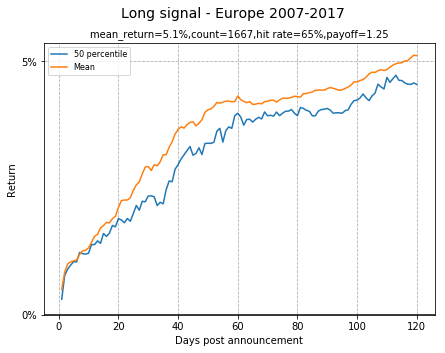

In [81]:
perf_chart_day(signal1_abs_df_Europe,"Days post announcement",
           "Return","Long signal - Europe 2007-2017",[7,5],
          [0.5])

In [83]:
perf_chart_day(signal1_rel_df_Europe,"Days post announcement",
           "Return","Long signal - Europe 2007-2017",[7,5],
          [0.5])

NameError: name 'signal1_rel_df_Europe' is not defined

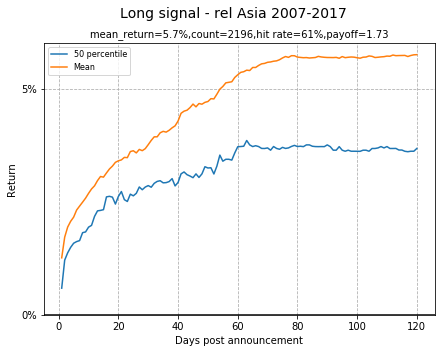

In [166]:
perf_chart_day(signal1_rel_df_Asia,"Days post announcement",
           "Return","Long signal - rel Asia 2007-2017",[7,5],
          [0.5])

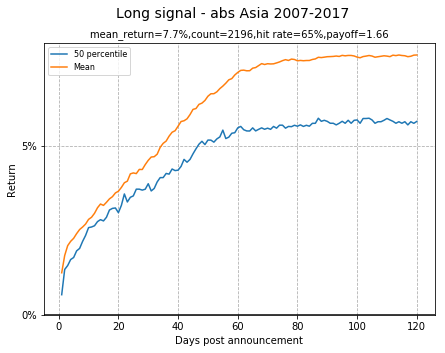

In [88]:
perf_chart_day(signal1_abs_df_Asia,"Days post announcement",
           "Return","Long signal - abs Asia 2007-2017",[7,5],
          [0.5])

In [86]:
perf_chart_day(signal1_abs_df_US,"Days post announcement",
           "Return","Long signal - US 2007-2017",[7,5],
          [0.5])

NameError: name 'signal1_abs_df_US' is not defined

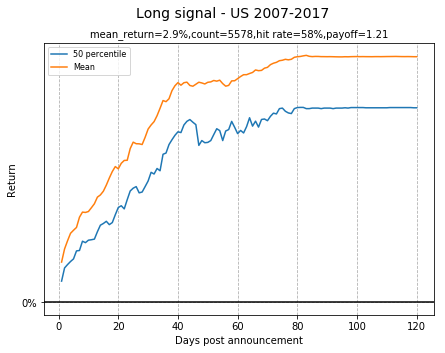

In [86]:
perf_chart_day(signal1_rel_df_US,"Days post announcement",
           "Return","Long signal - US 2007-2017",[7,5],
          [0.5])

## 5 - Account curve for long

Simulated performance of the portfolio by actual dates
- Basic plot
- By sectors
- By countries
- By size
- By PE
- By PE premium
- By holding period
- By entry point
- Stop loss
- Drawdown
- Moving average
- High price
- **Signal combination**
- Correlation with markets
- Performance for the following results

### 5.1 - Basic plot

In [86]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_open_ret_Europe,-1000,1000,40,False,False,1)
signal1_abs_df_date_Europe1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,abs_open_ret_Europe,-1000,1000,40,False,False,1)

In [87]:
# singal1 dataframe by actual date US
signal1_rel_df_date_US1_40=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,1,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-1000,1000,40,False,False,1)
signal1_abs_df_date_US1_40=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_open_ret_US,-1000,1000,40,False,False,1)

In [167]:
# singal1 dataframe by actual date Asia
signal1_rel_df_date_Asia1_30=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,30,False,False,1)
signal1_abs_df_date_Asia1_30=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,30,False,False,1)

In [88]:
# singal1 dataframe by actual date Asia
signal1_rel_df_date_Asia1_40=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,40,False,False,1)
signal1_abs_df_date_Asia1_40=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,40,False,False,1)

In [209]:
Asian_long_test_40d=slice_universe(signal1_rel_df_date_Asia1_40,datetime(2015,1,1),datetime(2017,12,31))

In [213]:
signal_long_asia=signal1_rel_df_date_Asia1_40.copy().T

In [214]:
signal_long_asia["country"]=signal_long_asia.apply(lambda x: x.name[0][-2:],axis=1)

In [231]:
signal_HK=signal_long_asia[signal_long_asia.country=='HK'].T.iloc[:-1]
signal_TW=signal_long_asia[signal_long_asia.country=='TT'].T.iloc[:-1]
signal_AU=signal_long_asia[signal_long_asia.country=='AU'].T.iloc[:-1]
signal_JP=signal_long_asia[signal_long_asia.country=='JP'].T.iloc[:-1]
signal_KS=signal_long_asia[signal_long_asia.country=='KS'].T.iloc[:-1]

In [232]:
signal_HK_test=slice_universe(signal_HK,datetime(2015,1,1),datetime(2017,12,31))
signal_TW_test=slice_universe(signal_TW,datetime(2015,1,1),datetime(2017,12,31))
signal_AU_test=slice_universe(signal_AU,datetime(2015,1,1),datetime(2017,12,31))
signal_JP_test=slice_universe(signal_JP,datetime(2015,1,1),datetime(2017,12,31))
signal_KS_test=slice_universe(signal_KS,datetime(2015,1,1),datetime(2017,12,31))

In [89]:
# singal1 dataframe by actual date Asia
signal1_rel_df_date_Asia1_50=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,50,False,False,1)
signal1_abs_df_date_Asia1_50=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,50,False,False,1)

In [90]:
# singal1 dataframe by actual date Asia
signal1_rel_df_date_Asia1_60=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,60,False,False,1)
signal1_abs_df_date_Asia1_60=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,60,False,False,1)

In [182]:
Asia_LS=signal1_account_LS(signal1_abs_df_date_Asia1_40,signal1_abs_df_date_Asia_short1_40,30,15,50,data_dict_Asia["Volume"],
                   data_dict_Asia["Date"],0.1,True,abs_return_Asia,abs_return_Asia.loc["MXAP Index"],0,'constant',8,8)

In [180]:
Asia_LS_new=signal1_account_LS_Asia(signal1_abs_df_date_Asia1_40,signal1_abs_df_date_Asia_short1_20,30,15,50,data_dict_Asia["Volume"],
                                data_dict_Asia["Date"],0.1,True,abs_return_Asia,abs_return_Asia,data_dict_Asia["Mapping"]
                                ,0,'constant',8,8)

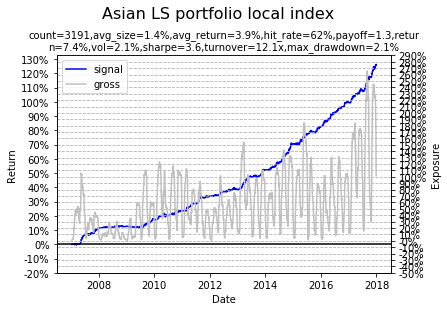

In [181]:
plot_account_curve(Asia_LS_new,
                   "Date","Asian LS portfolio local index",[6,4])

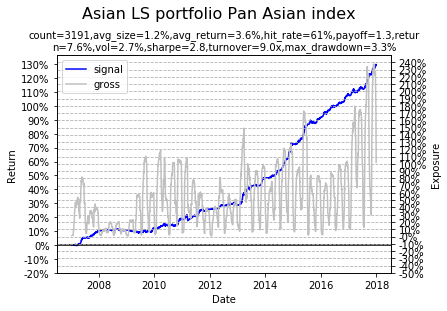

In [243]:
plot_account_curve(Asia_LS,
                   "Date","Asian LS portfolio Pan Asian index",[6,4])

In [300]:
Europe_LS=signal1_account_LS(signal1_abs_df_date_Europe1_40,large_signal1_abs_df_date_Europe_short1_40,30,15,50,data_dict_Europe["Volume"],
                   data_dict_Europe["Date"],0.1,True,abs_return_Europe,abs_return_Europe.loc["SX5E Index"],0,'constant',8,8)

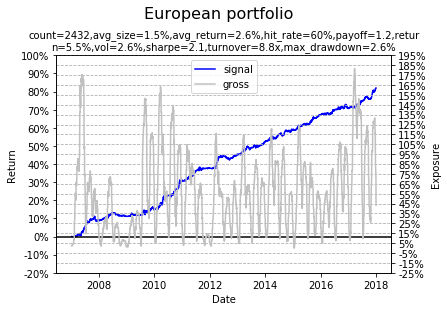

In [301]:
plot_account_curve(Europe_LS,
                   "Date","European portfolio",[6,4])

In [305]:
US_LS=signal1_account_LS(signal1_abs_df_date_US1_40,large_signal1_abs_df_date_US_short1_40,30,15,50,data_dict_US["Volume"],
                   data_dict_US["Date"],0.1,True,abs_return_US,abs_return_US.loc["SPX Index"],0,'constant',8,8)


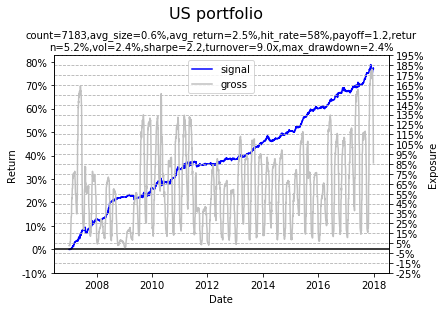

In [306]:
plot_account_curve(US_LS,
                   "Date","US portfolio",[6,4])

In [ ]:
global_LS=signal1_account_combine(test_signal1_abs_Europe1_40, test_large_signal1_abs_df_date_Europe_short1_40,
                        test_signal1_abs_US1_40, test_large_signal1_abs_df_date_US_short1_40, 30, 15, 
                        50, 50, data_dict_global["Volume"], data_dict_global["Date"], True, abs_return_Europe, abs_return_US, 
                        0.1, abs_return_Europe.loc["SX5E Index"], abs_return_US.loc["SPX Index"], 0, 'constant', 8,8)

In [ ]:
plot_account_curve(global_LS,
                   "Date","Global portfolio",[6,4])

In [ ]:
## Number of stocks chart
global_area=pd.concat([global_LS[-1][0][0].sum(axis=1),global_LS[-1][0][2].sum(axis=1),
                    global_LS[-1][1][0].sum(axis=1),global_LS[-1][1][2].sum(axis=1)],axis=1)

global_area.columns=["European long", "European short", "US long", "US short"]

global_area.plot.area(figsize=(8,5),title="Number of stocks",fontsize=10)

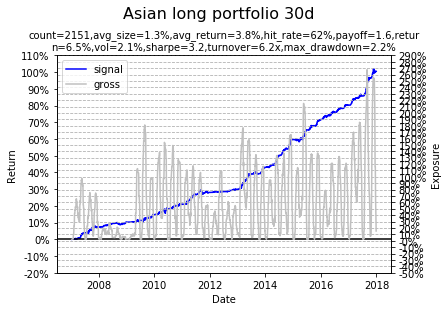

In [169]:
plot_account_curve(signal1_account(signal1_rel_df_date_Asia1_30,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","Asian long portfolio 30d",[6,4])

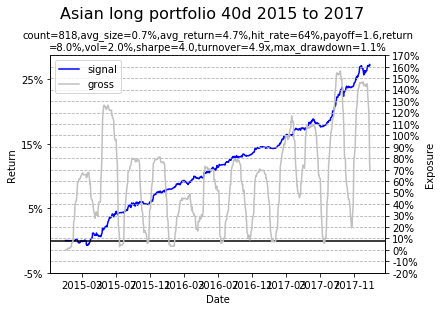

In [210]:
plot_account_curve(signal1_account(Asian_long_test_40d,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","Asian long portfolio 40d 2015 to 2017",[6,4])

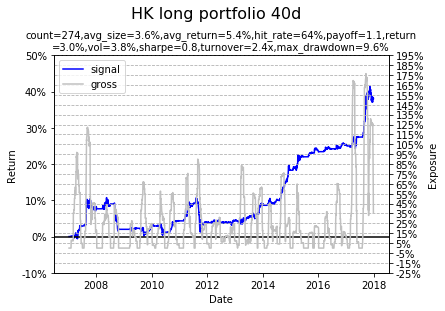

In [226]:
plot_account_curve(signal1_account(signal_HK,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","HK long portfolio 40d",[6,4])

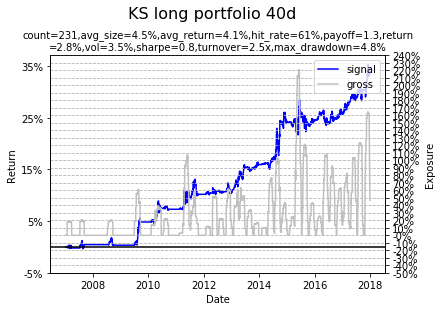

In [240]:
plot_account_curve(signal1_account(signal_KS,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","KS long portfolio 40d",[6,4])

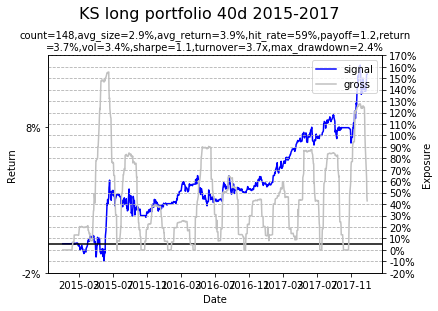

In [242]:
plot_account_curve(signal1_account(signal_KS_test,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","KS long portfolio 40d 2015-2017",[6,4])

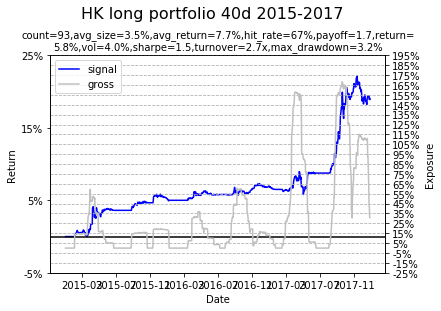

In [227]:
plot_account_curve(signal1_account(signal_HK_test,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","HK long portfolio 40d 2015-2017",[6,4])

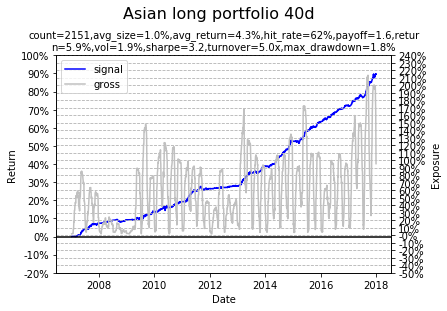

In [168]:
plot_account_curve(signal1_account(signal1_rel_df_date_Asia1_40,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","Asian long portfolio 40d",[6,4])

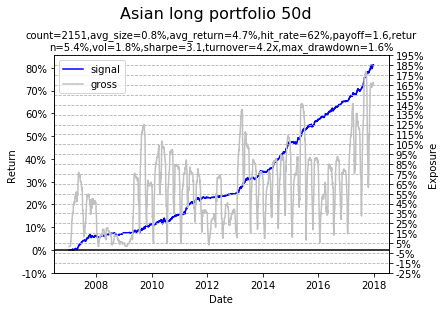

In [93]:
plot_account_curve(signal1_account(signal1_rel_df_date_Asia1_50,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","Asian long portfolio 50d",[6,4])

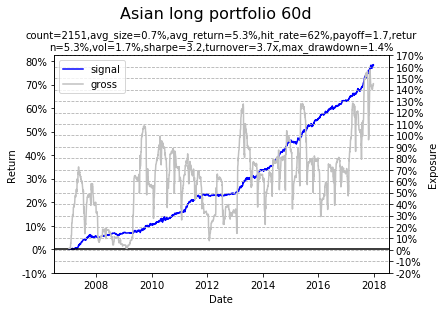

In [94]:
plot_account_curve(signal1_account(signal1_rel_df_date_Asia1_60,30,50,data_dict_Asia["Volume"],data_dict_Asia["Date"],0.1),
                   "Date","Asian long portfolio 60d",[6,4])

In [ ]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe1_40,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European long portfolio",[6,4])

### 5.2 - Feature combination

In [94]:
# EAR,revision,rating,gap,highest down,highest drawdown,distance to recent high,cumulative return,distance to moving average,RSI,AUTOR
def aggregate_feature(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,
                      open_ret,holding,entry,market_cap,price_df,high_lookback,RSI_lookback,MA_lookback,rel_index,
                      PE_df,PE_premium_df,sector_df,EPS_df,broker_df):
    
    signal_df=signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,
                              open_ret,-1000,1000,holding,False,False,entry)

    signal_df_abs=signal1_df_date(date_df,return_for_signal,return_for_signal,EAR_low,EAR_high,revision_df,revision_low,revision_high,
                              open_ret,-1000,1000,holding,False,False,entry)
    
    cum_ret=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    cum_ret.name="Cum_ret"
    aggregate_df=cum_ret.to_frame()
    
    aggregate_df["Market_cap"]=signal_df.apply(lambda x: get_market_cap(x.name[0],x.name[1],market_cap,date_df),axis=0)
    aggregate_df["Gap"]=signal_df.apply(lambda x: gap_calc(x.name[0],x.name[1],open_ret,return_for_signal,30),axis=0)
    aggregate_df["EAR"]=signal_df.apply(lambda x: EAR_calc(x.name[0],x.name[1],return_for_signal,entry,30),axis=0)
    aggregate_df["Intraday"]=signal_df.apply(lambda x: EAR_calc(x.name[0],x.name[1],return_for_signal,1,30),axis=0)-aggregate_df["Gap"]
    
    aggregate_df["Revision"]=signal_df.apply(lambda x: get_revision(x.name[0],x.name[1],revision_df,date_df),axis=0)
    aggregate_df["Rating"]=aggregate_df["EAR"]-aggregate_df["Revision"]
    aggregate_df["Vol"]=signal_df.apply(lambda column:signal1_vol(column,return_for_signal,30),axis=0)
    #signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/aggregate_df["Vol"]
    
    aggregate_df["Distance_high"]=signal_df.apply(lambda x: get_high_position(x.name[0],x.name[1],price_df,high_lookback),axis=0)
    aggregate_df["RSI"]=signal_df.apply(lambda x: RSI(x.name[0],x.name[1],return_for_signal,RSI_lookback),axis=0)
    aggregate_df["AUTOR"]=signal_df.apply(lambda x: AUTOR(x.name[0],x.name[1],150,price_df,rel_index)[0],axis=0)
    
    for i in MA_lookback:
        aggregate_df["MA"+str(i)]=signal_df.apply(lambda x: MA(x.name[0],x.name[1],i,price_df,None)[0],axis=0)
    
    aggregate_df["PE"]=signal_df.apply(lambda x: get_PE(x.name[0],x.name[1],PE_df,date_df),axis=0)
    aggregate_df["PE_premium"]=signal_df.apply(lambda x: get_PE_premium(x.name[0],x.name[1],PE_premium_df,date_df),axis=0)
    aggregate_df["Sector"]=signal_df.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    aggregate_df["EPS"]=signal_df.apply(lambda x: get_EPS(x.name[0],x.name[1],EPS_df,date_df),axis=0)
    aggregate_df["Broker"]=signal_df.apply(lambda x: get_broker(x.name[0],x.name[1],broker_df,date_df),axis=0)
    aggregate_df["Price"]=signal_df.apply(lambda x: get_price(x.name[0],x.name[1],price_df),axis=0)
    aggregate_df["Yield"]=aggregate_df["EPS"]/aggregate_df["Price"]
    aggregate_df["EPS_chg"]=aggregate_df["EPS"].abs()*aggregate_df["Revision"]/aggregate_df["Price"]
    
    #aggregate_df=aggregate_df.dropna(axis=0)
    
    return aggregate_df.transpose()                    

In [98]:
feature_Europe1=aggregate_feature(data_dict_Europe["Date"],abs_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe["Revision"],
                                 -1000,1000,abs_open_ret_Europe,40,1,data_dict_Europe["Market cap"],price_Europe,120,14,[50,150],
                                 "SX5E Index",data_dict_Europe["PE"],data_dict_Europe["PE premium"],
                                 data_dict_Europe["Property"]["Sector"])

In [92]:
feature_US1=aggregate_feature(data_dict_US["Date"],abs_return_US,rel_return_US,-1000,1000,data_dict_US["Revision"],
                                 -1000,1000,abs_open_ret_US,40,1,data_dict_US["Market cap"],price_US,120,14,[50,150],
                                 "SPX Index",data_dict_US["PE"],data_dict_US["PE premium"],
                                 data_dict_US["Property"]["Sector"],data_dict_US["EPS"],data_dict_US["Broker"])
                                 

In [96]:
feature_Asia1=aggregate_feature(data_dict_Asia["Date"],abs_return_Asia,rel_return_Asia,-1000,1000,data_dict_Asia["Revision"],
                                 -1000,1000,rel_return_Asia,40,1,data_dict_Asia["Market cap"],price_Asia,120,14,[50,150],
                                 "MXAP Index",data_dict_Asia["PE"],data_dict_Asia["PE premium"],
                                 data_dict_Asia["Property"]["Sector"],data_dict_Asia["EPS"],data_dict_Asia["Broker"])
                                 

In [100]:
def slice_feature(feature_df,start_datetime,end_datetime):
    entry=feature_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
    signal_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
    adj_feature_df=feature_df.loc[:,signal_evaluate]
    #adj_feature_df=adj_feature_df.dropna(axis=0,how="all")
    if type(adj_feature_df.index[0])==pd._libs.tslib.Timestamp:
        period_evaluate=adj_feature_df.apply(lambda x:(x.name>=start_datetime)&(x.name<=end_datetime),axis=1)
        adj_feature_df=adj_feature_df.loc[period_evaluate]
    return adj_feature_df.transpose()

In [ ]:
training_Europe1=slice_feature(feature_Europe1,datetime(2011,1,1),datetime(2015,12,31))
test_Europe1=slice_feature(feature_Europe1,datetime(2016,1,1),datetime(2017,12,31))
crisis_Europe1=slice_feature(feature_Europe1,datetime(2007,1,1),datetime(2010,12,31))
training_US1=slice_feature(feature_US1,datetime(2011,1,1),datetime(2015,12,31))
test_US1=slice_feature(feature_US1,datetime(2016,1,1),datetime(2017,12,31))
crisis_US1=slice_feature(feature_US1,datetime(2007,1,1),datetime(2010,12,31))

In [104]:
training_Asia1=slice_feature(feature_Asia1,datetime(2011,1,1),datetime(2015,12,31))
test_Asia1=slice_feature(feature_Asia1,datetime(2016,1,1),datetime(2017,12,31))
crisis_Asia1=slice_feature(feature_Asia1,datetime(2007,1,1),datetime(2010,12,31))

In [204]:
training_US1=slice_feature(feature_US1,datetime(2011,1,1),datetime(2015,12,31))
test_US1=slice_feature(feature_US1,datetime(2016,1,1),datetime(2017,12,31))
crisis_US1=slice_feature(feature_US1,datetime(2007,1,1),datetime(2010,12,31))

In [112]:
Asia_long=feature_Asia1.transpose()[(feature_Asia1.transpose().EAR>=1)&(feature_Asia1.transpose().Revision>=0.03)]
Asia_training_long=training_Asia1[(training_Asia1.EAR>=1)&(training_Asia1.Revision>=0.03)]
Asia_test_long=test_Asia1[(test_Asia1.EAR>=1)&(test_Asia1.Revision>=0.03)]
Asia_crisis_long=crisis_Asia1[(crisis_Asia1.EAR>=1)&(crisis_Asia1.Revision>=0.03)]

In [113]:
Asia_short=feature_Asia1.transpose()[(feature_Asia1.transpose().EAR<=-2)&(feature_Asia1.transpose().Revision<=-0.03)]
Asia_training_short=training_Asia1[(training_Asia1.EAR<=-2)&(training_Asia1.Revision<=-0.03)]
Asia_test_short=test_Asia1[(test_Asia1.EAR<=-2)&(test_Asia1.Revision<=-0.03)]
Asia_crisis_short=crisis_Asia1[(crisis_Asia1.EAR<=-2)&(crisis_Asia1.Revision<=-0.03)]

In [ ]:
Europe_long=feature_Europe1.transpose()[(feature_Europe1.transpose().EAR>=1)&(feature_Europe1.transpose().Revision>=0.03)]
Europe_training_long=training_Europe1[(training_Europe1.EAR>=1)&(training_Europe1.Revision>=0.03)]
Europe_test_long=test_Europe1[(test_Europe1.EAR>=1)&(test_Europe1.Revision>=0.03)]
Europe_crisis_long=crisis_Europe1[(crisis_Europe1.EAR>=1)&(crisis_Europe1.Revision>=0.03)]

In [ ]:
US_long=feature_US1.transpose()[(feature_US1.transpose().EAR>=2)&(feature_US1.transpose().Revision>=0.05)]
US_training_long=training_US1[(training_US1.EAR>=2)&(training_US1.Revision>=0.05)]
US_test_long=test_US1[(test_US1.EAR>=2)&(test_US1.Revision>=0.05)]
US_crisis_long=crisis_US1[(crisis_US1.EAR>=2)&(crisis_US1.Revision>=0.05)]

In [ ]:
Europe_short=feature_Europe1.transpose()[(feature_Europe1.transpose().EAR<=-2)&(feature_Europe1.transpose().Revision<-0.03)&(feature_Europe1.transpose().Market_cap>5000)]
Europe_short_small=feature_Europe1.transpose()[(feature_Europe1.transpose().EAR<=-2)&(feature_Europe1.transpose().Revision<-0.03)&(feature_Europe1.transpose().Market_cap<2000)]
Europe_training_short=training_Europe1[(training_Europe1.EAR<=-2)&(training_Europe1.Revision<-0.03)&(training_Europe1.Market_cap>5000)]
Europe_test_short=test_Europe1[(test_Europe1.EAR<=-2)&(test_Europe1.Revision<-0.03)&(test_Europe1.Market_cap>5000)]
Europe_crisis_short=crisis_Europe1[(crisis_Europe1.EAR<=-2)&(crisis_Europe1.Revision<-0.03)&(crisis_Europe1.Market_cap>5000)]

In [ ]:
Europe_training_short=training_Europe1[(training_Europe1.EAR<=-2)&(training_Europe1.Revision<-0.03)]
Europe_test_short=test_Europe1[(test_Europe1.EAR<=-2)&(test_Europe1.Revision<-0.03)]
Europe_crisis_short=crisis_Europe1[(crisis_Europe1.EAR<=-2)&(crisis_Europe1.Revision<-0.03)]

In [ ]:
US_short=feature_US1.transpose()[(feature_US1.transpose().EAR<=-2)&(feature_US1.transpose().Revision<-0.03)]
US_short_small=feature_US1.transpose()[(feature_US1.transpose().EAR<=-2)&(feature_US1.transpose().Revision<-0.03)&(feature_US1.transpose().Market_cap<2000)]

US_training_short_small=training_US1[(training_US1.EAR<=-2)&(training_US1.Revision<-0.03)&(training_US1.Market_cap<2000)]
US_test_short_small=test_US1[(test_US1.EAR<=-2)&(test_US1.Revision<-0.03)&(test_US1.Market_cap<2000)]
US_crisis_short_small=crisis_US1[(crisis_US1.EAR<=-2)&(crisis_US1.Revision<-0.03)&(crisis_US1.Market_cap<2000)]

US_training_short=training_US1[(training_US1.EAR<=-2)&(training_US1.Revision<-0.03)&(training_US1.Market_cap>5000)]
US_test_short=test_US1[(test_US1.EAR<=-2)&(test_US1.Revision<-0.03)&(test_US1.Market_cap>5000)]
US_crisis_short=crisis_US1[(crisis_US1.EAR<=-2)&(crisis_US1.Revision<-0.03)&(crisis_US1.Market_cap>5000)]

In [ ]:
US_training_short=training_US1[(training_US1.EAR<=-2)&(training_US1.Revision<-0.03)]
US_test_short=test_US1[(test_US1.EAR<=-2)&(test_US1.Revision<-0.03)]
US_crisis_short=crisis_US1[(crisis_US1.EAR<=-2)&(crisis_US1.Revision<-0.03)]

In [ ]:
US_short=feature_US1.transpose()[(feature_US1.transpose().EAR<=-2)&(feature_US1.transpose().Revision<-0.03)]
US_training_short=training_US1[(training_US1.EAR<=-2)&(training_US1.Revision<-0.03)]
US_test_short=test_US1[(test_US1.EAR<=-2)&(test_US1.Revision<-0.03)]
US_crisis_short=crisis_US1[(crisis_US1.EAR<=-2)&(crisis_US1.Revision<-0.03)]

In [124]:
def feature_grid(feature_df,feature,value_list):
    feature_dict={}

    for idx in range(len(value_list)-1):
        my_feature=feature_df[(feature_df[feature]>=value_list[idx])&(feature_df[feature]<=value_list[idx+1])]
        feature_dict[str(feature)+" "+str(value_list[idx])+str(" to ")+str(value_list[idx+1])]=my_feature["Cum_ret"].mean()

    feature_series=pd.Series(np.zeros(len(value_list)-1),
                           index=[str(feature)+" "+str(value_list[i])+str(" to ")+str(value_list[i+1]) for i in range(len(value_list)-1)])

    for i,ival in enumerate(feature_series.index.tolist()):
            feature_series[i]=round(feature_dict[ival],3)
    
    return feature_series

In [108]:
def EAR_upgrade_ret_grid(EAR_list,revision_list,feature_df,start_datetime,end_datetime):
    EAR_upgrade_dict={}
    
    training_set=slice_feature(feature_df,start_datetime,end_datetime)

    for idx in range(len(EAR_list)-1):
        for i in range(len(revision_list)-1):
            training_EAR=training_set[(training_set.EAR>=EAR_list[idx])&(training_set.EAR<EAR_list[idx+1])]
            training_EAR_upgrade=training_EAR[(training_EAR.Revision>=revision_list[i])&(training_EAR.Revision<revision_list[i+1])]
            EAR_upgrade_dict[("Move "+str(EAR_list[idx])+str(" to ")+str(EAR_list[idx+1]),
                              "Upgrade "+str("{:.1%}".format(revision_list[i]))+str(" to ")+str("{:.1%}".format(revision_list[i+1])))]=training_EAR_upgrade["Cum_ret"].mean()

    EAR_upgrade_ret=pd.DataFrame(np.zeros((len(EAR_list)-1,len(revision_list)-1)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_list[i]))+str(" to ")+str("{:.1%}".format(revision_list[i+1])) for i in range(len(revision_list)-1)],
                  index=["Move "+str(round(EAR_list[i],1))+str(" to ")+str(round(EAR_list[i+1],1)) for i in range(len(EAR_list)-1)])

    for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
        for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
            EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)],3)
    
    return EAR_upgrade_ret

In [109]:
def EAR_upgrade_ret_bound(EAR_list,revision_list,feature_df,start_datetime,end_datetime):
    EAR_upgrade_dict={}
    
    training_set=slice_universe(feature_df,start_datetime,end_datetime)

    for idx in range(len(EAR_list)-1):
        for i in range(len(revision_list)-1):
            training_EAR=training_set[(training_set.EAR>=EAR_list[idx])]#&(training_set.EAR<EAR_list[idx+1])]
            training_EAR_upgrade=training_EAR[(training_EAR.Revision>=revision_list[i])]#&(training_EAR.Revision<revision_list[i+1])]
            EAR_upgrade_dict[("Move "+str(EAR_list[idx])+str(" above"),
                              "Upgrade "+str("{:.1%}".format(revision_list[i]))+str(" above"))]=training_EAR_upgrade["Cum_ret"].mean()

    EAR_upgrade_ret=pd.DataFrame(np.zeros((len(EAR_list)-1,len(revision_list)-1)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_list[i]))+str(" above") for i in range(len(revision_list)-1)],
                  index=["Move "+str(round(EAR_list[i],1))+str(" above") for i in range(len(EAR_list)-1)])

    for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
        for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
            EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)],3)
    
    return EAR_upgrade_ret

In [148]:
Asia_training_long.Yield.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

0.0    -0.318178
0.1    0.0304443
0.2    0.0439485
0.3    0.0522472
0.4    0.0601399
0.5    0.0678205
0.6     0.076269
0.7    0.0878327
0.8     0.101303
0.9      0.11841
1.0     0.266033
Name: Yield, dtype: object

In [134]:
feature_grid(feature_Asia1.T,'Yield',[0,5,10,15,20,1000])

Broker 0 to 5        0.012
Broker 5 to 10       0.009
Broker 10 to 15      0.010
Broker 15 to 20      0.007
Broker 20 to 1000    0.007
dtype: float64

In [152]:
feature_grid(Asia_training_long,'Yield',[-1000,-0.05,0,0.05,0.08,0.1,1000])

Yield -1000 to -0.05   -0.009
Yield -0.05 to 0       -0.059
Yield 0 to 0.05         0.046
Yield 0.05 to 0.08      0.029
Yield 0.08 to 0.1       0.035
Yield 0.1 to 1000       0.039
dtype: float64

In [146]:
feature_grid(Asia_test_long,'Yield',[-1000,0,0.05,0.08,0.1,1000])

Yield -1000 to 0     -0.029
Yield 0 to 0.05       0.029
Yield 0.05 to 0.08    0.039
Yield 0.08 to 0.1     0.033
Yield 0.1 to 1000     0.065
dtype: float64

In [147]:
feature_grid(Asia_crisis_long,'Yield',[-1000,0,0.05,0.08,0.1,1000])

Yield -1000 to 0      0.039
Yield 0 to 0.05       0.022
Yield 0.05 to 0.08    0.030
Yield 0.08 to 0.1     0.054
Yield 0.1 to 1000     0.018
dtype: float64

In [122]:
EAR_upgrade_ret_grid([-1000,-4,-2,0,1,2,3,4,6,1000],[-1000,-0.1,-0.05,-0.03,-0.01,0,0.01,0.03,0.05,0.1,1000],feature_Asia1,datetime(2011,1,1),datetime(2015,12,31))

,Upgrade -100000.0% to -10.0%,Upgrade -10.0% to -5.0%,Upgrade -5.0% to -3.0%,Upgrade -3.0% to -1.0%,Upgrade -1.0% to 0.0%,Upgrade 0.0% to 1.0%,Upgrade 1.0% to 3.0%,Upgrade 3.0% to 5.0%,Upgrade 5.0% to 10.0%,Upgrade 10.0% to 100000.0%
Move -1000 to -4,-0.014,-0.005,-0.008,-0.015,0.005,-0.003,0.019,0.024,-0.005,0.081
Move -4 to -2,-0.024,-0.021,-0.021,-0.005,-0.005,0.010,0.020,0.017,0.055,0.090
Move -2 to 0,-0.019,-0.017,-0.003,-0.008,0.006,0.014,0.020,0.038,0.051,0.064
Move 0 to 1,-0.017,-0.025,-0.013,-0.016,-0.001,0.011,0.017,0.038,0.054,0.061
Move 1 to 2,-0.016,-0.022,-0.031,-0.011,-0.000,0.019,0.022,0.054,0.037,0.054
Move 2 to 3,-0.043,-0.015,-0.007,-0.002,-0.004,0.028,0.021,0.028,0.050,0.048
Move 3 to 4,0.012,0.070,-0.033,0.024,0.059,0.018,0.031,0.024,0.066,0.029
Move 4 to 6,0.013,-0.017,0.023,0.003,0.011,-0.006,0.018,0.048,0.029,0.060
Move 6 to 1000,-0.089,0.013,-0.030,-0.001,-0.003,0.055,0.009,0.014,0.032,0.055


In [ ]:
EAR_upgrade_ret_grid([-1000,-4,-2,0,1,2,3,4,6,1000],[-1000,-0.04,-0.02,0,0.01,0.02,0.03,0.05,0.1,0.2,1000],feature_Asia1,datetime(2016,1,1),datetime(2017,12,31))

In [ ]:
EAR_upgrade_ret_grid([-1000,-4,-2,0,1,2,3,4,6,1000],[-1000,-0.04,-0.02,0,0.01,0.02,0.03,0.05,0.1,0.2,1000],feature_Asia1,datetime(2007,1,1),datetime(2010,12,31))

In [ ]:
EAR_upgrade_ret_grid([-1000,-4,-2,0,1,2,3,4,6,1000],[-1000,-0.04,-0.02,0,0.01,0.02,0.03,0.05,0.1,0.2,1000],feature_Asia1,datetime(2007,1,1),datetime(2017,12,31))

### 5.3 - Account curve by size

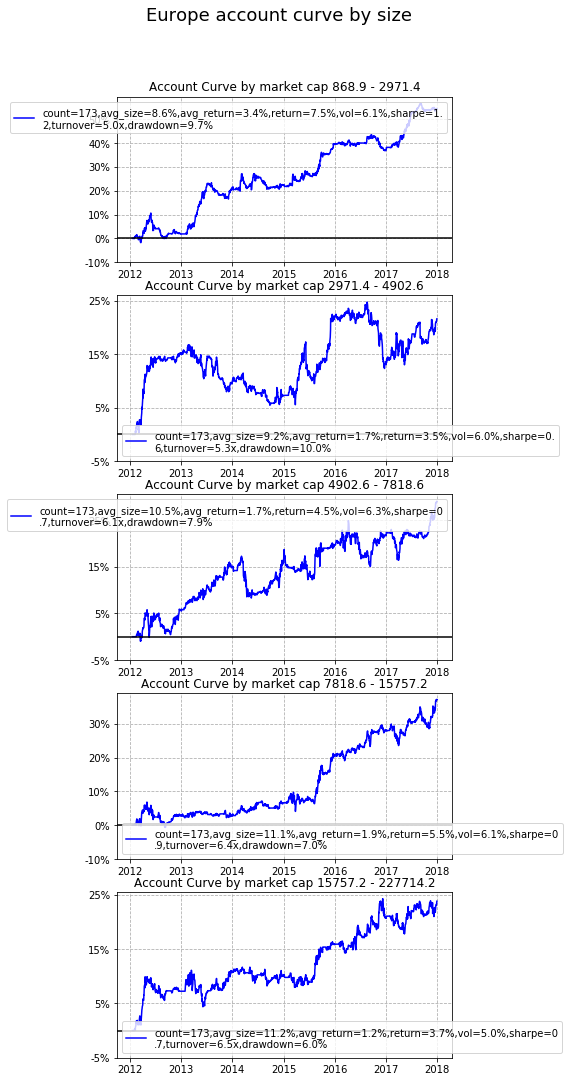

In [444]:
plot_account_curve_by_size([0,0.2,0.4,0.6,0.8,1],(6,25),18 ,
                            "Europe account curve by size",signal1_rel_df_date_Europe,
                            50,10,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["Market cap"],0.1)

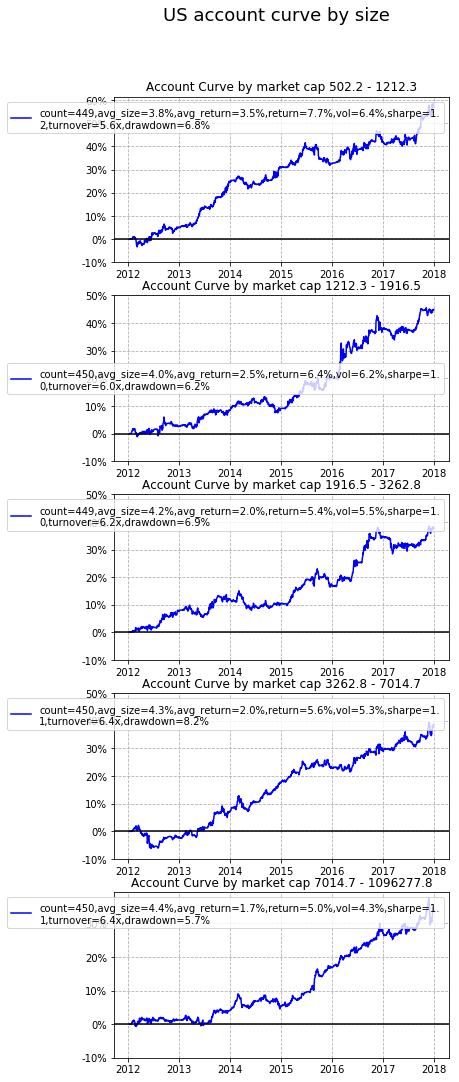

In [445]:
plot_account_curve_by_size([0,0.2,0.4,0.6,0.8,1],(6,25),18,
                            "US account curve by size",signal1_rel_df_date_US,
                            50,20,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["Market cap"],0.1)

## 6 - Average return trajectory for short

In [424]:
# Short signal dataframe Europe
#signal1_rel_df_short_Europe=signal1_df_day(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_open_ret_Europe,-1000,1000,120,False,False,1)
signal1_abs_df_short_Europe=signal1_df_day(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_open_ret_Europe,-1000,1000,120,False,False,1)
signal1_abs_df_short_US=signal1_df_day(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_open_ret_US,-1000,1000,120,False,False,1)

In [425]:
signal1_rel_df_short_Europe=signal1_df_day(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_open_ret_Europe,-1000,1000,120,False,False,1)
signal1_rel_df_short_US=signal1_df_day(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_open_ret_US,-1000,1000,120,False,False,1)

In [170]:
signal1_rel_df_short_Asia=signal1_df_day(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,120,False,False,1)

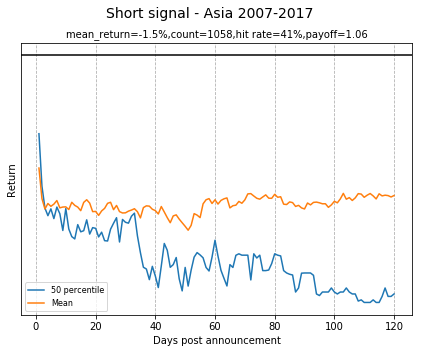

In [175]:
perf_chart_day(signal1_rel_df_short_Asia,"Days post announcement","Return","Short signal - Asia 2007-2017",[7,5],
               [0.5])

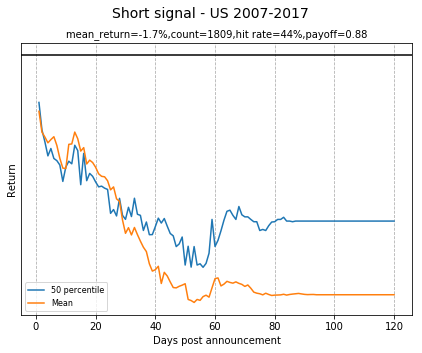

In [235]:
perf_chart_day(large_rel_short_US
               ,"Days post announcement","Return","Short signal - US 2007-2017",[7,5],
               [0.5])

## 7 - Account curve for short

Simulated performance of the portfolio by actual dates
- Basic plot by holding period and next result
- By entry point
- By size
- By PE and PE premium
- By sectors
- Stop loss
- Performance for the following results

### 7.1 - Basic plot by holding period and next result

In [295]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Europe_short1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,rel_open_ret_Europe,-1000,1000,40,False,False,1)
signal1_abs_df_date_Europe_short1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_open_ret_Europe,-1000,1000,40,False,False,1)

In [296]:
# singal1 short dataframe by actual date US
signal1_rel_df_date_US_short1_40=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,rel_open_ret_US,-1000,1000,40,False,False,1)
signal1_abs_df_date_US_short1_40=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_open_ret_US,-1000,1000,40,False,False,1)

In [172]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Asia_short1_20=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,20,False,False,1)
signal1_abs_df_date_Asia_short1_20=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,20,False,False,1)

In [173]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Asia_short1_30=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,30,False,False,1)
signal1_abs_df_date_Asia_short1_30=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,30,False,False,1)

In [97]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Asia_short1_40=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,40,False,False,1)
signal1_abs_df_date_Asia_short1_40=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,40,False,False,1)

In [174]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Asia_short1_50=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,50,False,False,1)
signal1_abs_df_date_Asia_short1_50=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,-1000,-2,data_dict_Asia['Revision'],-1000,-0.03,rel_return_Asia,-1000,1000,50,False,False,1)

In [298]:
size_Europe_short=signal1_abs_df_date_Europe_short1_40.apply(lambda x:get_market_cap(x.name[0],x.name[1],data_dict_Europe["Market cap"],data_dict_Europe["Date"]),axis=0)
large_signal1_abs_df_date_Europe_short1_40=signal1_abs_df_date_Europe_short1_40.loc[:,size_Europe_short>5000]
small_signal1_abs_df_date_Europe_short1_40=signal1_abs_df_date_Europe_short1_40.loc[:,size_Europe_short<5000]

In [299]:
size_US_short=signal1_abs_df_date_US_short1_40.apply(lambda x:get_market_cap(x.name[0],x.name[1],data_dict_US["Market cap"],data_dict_US["Date"]),axis=0)
large_signal1_abs_df_date_US_short1_40=signal1_abs_df_date_US_short1_40.loc[:,size_US_short>5000]
small_signal1_abs_df_date_US_short1_40=signal1_abs_df_date_US_short1_40.loc[:,size_US_short<5000]

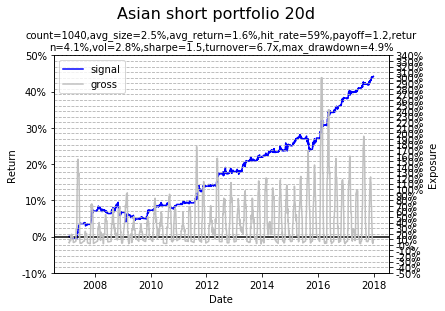

In [178]:
plot_account_curve(signal1_account(-signal1_rel_df_date_Asia_short1_20,30,50,data_dict_Asia["Volume"],
                                   data_dict_Asia["Date"],0.1),"Date","Asian short portfolio 20d",[6,4])

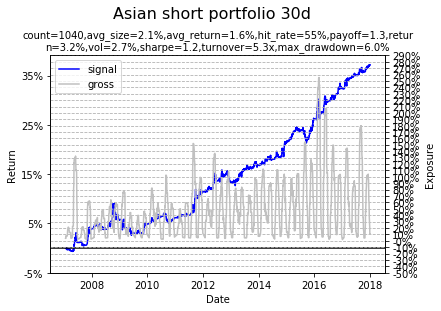

In [177]:
plot_account_curve(signal1_account(-signal1_rel_df_date_Asia_short1_30,30,50,data_dict_Asia["Volume"],
                                   data_dict_Asia["Date"],0.1),"Date","Asian short portfolio 30d",[6,4])

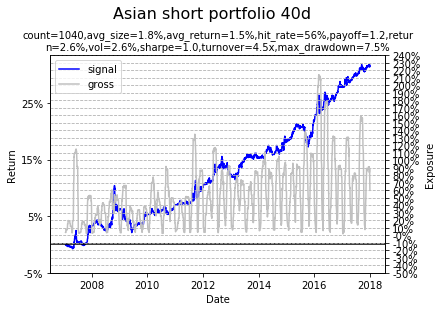

In [176]:
plot_account_curve(signal1_account(-signal1_rel_df_date_Asia_short1_40,30,50,data_dict_Asia["Volume"],
                                   data_dict_Asia["Date"],0.1),"Date","Asian short portfolio 40d",[6,4])

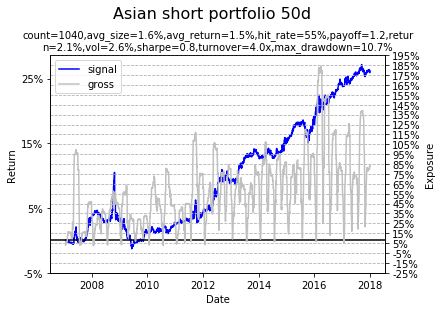

In [179]:
plot_account_curve(signal1_account(-signal1_rel_df_date_Asia_short1_50,30,50,data_dict_Asia["Volume"],
                                   data_dict_Asia["Date"],0.1),"Date","Asian short portfolio 50d",[6,4])

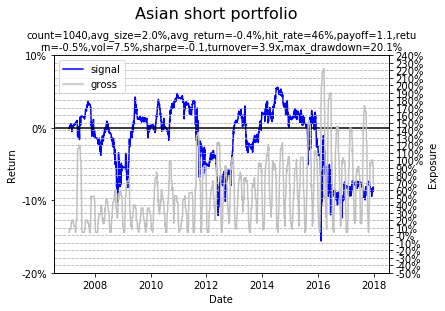

In [409]:
plot_account_curve(signal1_account(signal1_abs_df_date_Asia_short1_40,30,30,data_dict_Asia["Volume"],
                                   data_dict_Asia["Date"],0.1),"Date","Asian short portfolio",[6,4])

In [171]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_Europe_short1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,rel_open_ret_Europe,-1000,1000,40,False,False,1)
signal1_abs_df_date_Europe_short1_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_open_ret_Europe,-1000,1000,40,False,False,1)

In [480]:
# combine the US and Europe
signal1_rel_df_date_short_global=pd.concat([signal1_rel_df_date_short_US,signal1_rel_df_date_short_Europe],axis=1)
signal1_abs_df_date_short_global=pd.concat([signal1_abs_df_date_short_US,signal1_abs_df_date_short_Europe],axis=1)

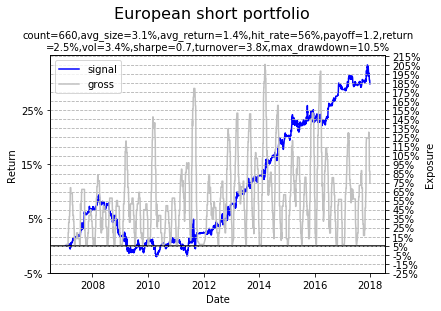

In [483]:
plot_account_curve(signal1_account(-large_signal1_rel_df_date_Europe_short1_40,30,40,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European short portfolio",[6,4])

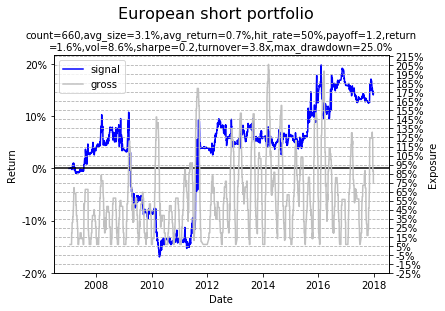

In [510]:
plot_account_curve(signal1_account(-large_signal1_abs_df_date_Europe_short1_40,30,40,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European short portfolio",[6,4])

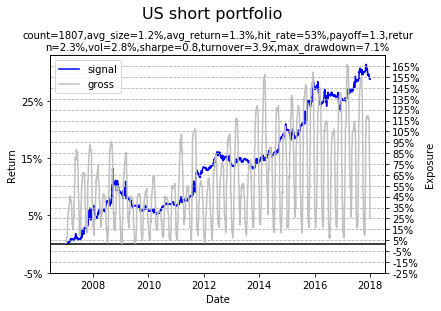

In [517]:
plot_account_curve(signal1_account(-large_signal1_rel_df_date_US_short1_40,
                                                       30,40,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US short portfolio",[6,4])

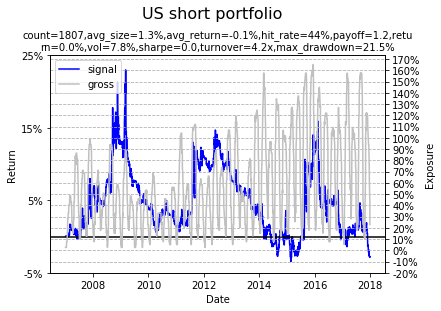

In [516]:
plot_account_curve(signal1_account(signal1_filter_stop(-large_signal1_abs_df_date_US_short1_40,8,abs_return_US,30),
                                                       30,40,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US short portfolio",[6,4])

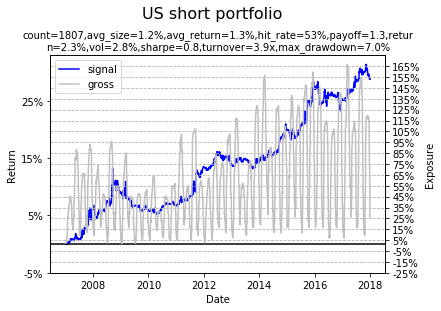

In [486]:
plot_account_curve(signal1_account(-large_signal1_rel_df_date_US_short1_40,30,60,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US short portfolio",[6,4])

## 9 - Logistic regression project 

In [68]:
def logit_data_df(date_df,return_df,EAR_period,vol_lookback,revision_df,PE_df,PE_premium_df,AUTOR_lookback_list,MA_lookback_list,price_df,rel_index,holding,entry,y_boundary):
    result_list=[]
    for ticker,row in date_df.iterrows():
        for date in row:
            if type(date)==pd._libs.tslib.Timestamp:
                result_list.append((ticker,date.strftime("%d/%b/%Y")))
            elif type(date)==str:
                result_list.append((ticker,date))
            else:
                pass
    
    logit_data_df=pd.DataFrame(result_list).set_index(0)
    logit_data_df.columns=["Date"]
    logit_data_df.index.name="Ticker"
    
    logit_data_df["EAR"]=logit_data_df.apply(lambda x:EAR_calc(x.name,x["Date"],return_df,EAR_period,vol_lookback),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["Revision"]=logit_data_df.apply(lambda x:get_revision(x.name,x["Date"],revision_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["PE"]=logit_data_df.apply(lambda x:get_PE(x.name,x["Date"],PE_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["PE premium"]=logit_data_df.apply(lambda x:get_PE_premium(x.name,x["Date"],PE_premium_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')

    for i in AUTOR_lookback_list:
        logit_data_df["AUTOR_"+str(i)+'D_score']=logit_data_df.apply(lambda x:AUTOR(x.name,x["Date"],i,price_df,rel_index)[0],axis=1)
        logit_data_df["AUTOR_"+str(i)+'D_slope']=logit_data_df.apply(lambda x:AUTOR(x.name,x["Date"],i,price_df,rel_index)[1],axis=1)    
    
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    for s in MA_lookback_list:
        logit_data_df["MA_"+str(s)+'D_score']=logit_data_df.apply(lambda x:MA(x.name,x["Date"],s,price_df,rel_index)[0],axis=1)
        logit_data_df["MA_"+str(s)+'D_slope']=logit_data_df.apply(lambda x:MA(x.name,x["Date"],s,price_df,rel_index)[1],axis=1)
    
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    logit_data_df["post move"]=logit_data_df.apply(lambda x:get_post_nmove(x.name,x["Date"],return_df,holding,entry),axis=1)>y_boundary
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    return logit_data_df
        

In [69]:
logit_data=logit_data_df(data_dict_US["Date"],rel_return_US,2,30,data_dict_US["Revision"],data_dict_US["PE"],data_dict_US["PE premium"],[100,150,200],[50,100,150,200],price_US,None,50,2,2)

In [70]:
logit_data_Europe=logit_data_df(data_dict_Europe["Date"],rel_return_Europe,2,30,data_dict_Europe["Revision"],data_dict_Europe["PE"],data_dict_Europe["PE premium"],[150],[50,150],price_Europe,None,50,2,2)

In [71]:
def data_normalise(data_df,lower_bound,upper_bound):
    z_score=data_df.iloc[:,1:-1].apply(stats.zscore)
    norm_xy=pd.concat([z_score[(z_score<upper_bound)&(z_score>lower_bound)],data_df.iloc[:,-1]],axis=1).dropna(axis=0,how='any')
    norm_x=norm_xy.iloc[:,:-1]
    norm_y=norm_xy.iloc[:,-1]
    x_orig=norm_x.as_matrix()
    y_orig=(norm_y*1.0).as_matrix().reshape(-1,1)
    return norm_x,norm_y

In [72]:
x_orig,y_orig=data_normalise(logit_data,-5,5)
x_orig_Europe,y_orig_Europe=data_normalise(logit_data_Europe,-5,5)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_orig,y_orig,test_size=0.25)
x_train_Europe,x_test_Europe,y_train_Europe,y_test_Europe=train_test_split(x_orig_Europe,y_orig_Europe,test_size=0.25)